## *Fauzan Akbar*

### `Latar Belakang`

Perusahaan properti yang beroperasi di saudi baru saja mengumpulkan data terkait penjualan mobil bekas di wilayah tersebut. Sebagai seorang data analyst yang baru bergabung, tugas Anda adalah menganalisis potensi bisnis dari data ini untuk membantu stakeholder dalam membuat keputusan strategis. Data yang diberikan mencakup informasi detail mengenai jenis mobil, wilayah penjualan, merek, tahun produksi, harga, dan fitur-fitur tambahan lainnya.

Dalam upaya memaksimalkan keuntungan dan mengoptimalkan distribusi, penting untuk memahami wilayah mana yang memiliki tingkat penjualan tertinggi dan seberapa kompetitif harga mobil bekas di masing-masing wilayah.

Tujuan:
Tujuan dari analisis ini adalah mengidentifikasi wilayah dengan tingkat penjualan mobil bekas tertinggi dan membuat model machine learning sebagai prediksi harga mobil berdasarkan berbagai faktornya seperti mesin, jarak tempuh dan lain sebagainya. Informasi ini akan membantu perusahaan dalam menentukan wilayah prioritas untuk pengembangan bisnis, pemasaran, dan strategi distribusi yang lebih efisien, masalah yang ingin saya analisis sebagai berikut:
1. Tingkat Penjualan Mobil Berdasarkan Wilayah
2. Analisis Harga Rata-rata untuk persaingan kompetitif
3. Analisis Daerah Potensial Berdasarkan Merek dan Tipe Mobil
4. Uji Hipotesis Pengaruh Tahun Produksi dan Jarak Tempuh terhadap Harga
5. Prediksi Harga Mobil Berdasarkan Faktor-faktor Teknis

#### `Initial Setup`

In [4]:
import numpy as np  
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

#### `Data Understanding`

In [5]:

data = pd.read_csv(r"C:\Users\Fauzan Akbar\Downloads\data_saudi_used_cars.csv")
print("Dataset awal:")
print(data.info())

Dataset awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB
None


### Data Cleaning


In [6]:
print(data.head())

          Type          Region        Make  Gear_Type       Origin    Options  \
0      Corolla            Abha      Toyota     Manual        Saudi   Standard   
1        Yukon          Riyadh         GMC  Automatic        Saudi       Full   
2  Range Rover          Riyadh  Land Rover  Automatic  Gulf Arabic       Full   
3       Optima  Hafar Al-Batin         Kia  Automatic        Saudi  Semi Full   
4           FJ          Riyadh      Toyota  Automatic        Saudi       Full   

   Year  Engine_Size  Mileage  Negotiable   Price  
0  2013          1.4   421000        True       0  
1  2014          8.0    80000       False  120000  
2  2015          5.0   140000       False  260000  
3  2015          2.4   220000       False   42000  
4  2020          4.0    49000        True       0  


In [7]:
data = data.drop_duplicates()
print(f"Setelah menghapus duplikat: {data.shape}")

Setelah menghapus duplikat: (5620, 11)


In [8]:
columns_to_drop = ['id']  
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
print(f"Setelah menghapus kolom tidak relevan: {data.shape}")

Setelah menghapus kolom tidak relevan: (5620, 11)


In [9]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = data[numerical_cols].apply(lambda col: col.fillna(col.median()))

categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

print(f"Setelah mengisi missing values: {data.isnull().sum().sum()} missing values tersisa")

Setelah mengisi missing values: 0 missing values tersisa


In [10]:
print(f"Final dataset size after all cleansing steps: {data.shape}")

Final dataset size after all cleansing steps: (5620, 11)


**penjelasan**
1. Menghapus Duplikasi
- Alasan: Data duplikat dapat menyebabkan hasil analisis menjadi bias. Menghapus duplikasi memastikan bahwa setiap baris data mewakili mobil yang unik, sehingga hasil perhitungan dan model lebih akurat.
2. Menangani Missing Values
- Numerik (Price, Mileage, Engine_Size): Missing values diisi dengan median karena median lebih tahan terhadap outliers.
Kategoris (Make, Region, Gear_Type): Missing values diisi dengan modus (nilai yang paling sering muncul), karena modus mewakili karakteristik umum data.
3. Menghapus Nilai 0 di Kolom Penting (Price, Mileage, Engine_Size)
- Alasan: Nilai 0 di kolom-kolom ini tidak realistis dan dapat menunjukkan kesalahan input data. Menghapus baris ini menjaga kualitas data agar analisis lebih valid.
4. Pengkodean Data Kategoris (One-Hot Encoding)
- Alasan: Model machine learning hanya dapat memproses data numerik. One-Hot Encoding mengubah data kategoris menjadi bentuk biner yang bisa digunakan oleh model.
5. Standarisasi Data Numerik
- Alasan: Standarisasi memastikan fitur numerik berada dalam skala yang sama, sehingga model seperti regresi linier atau k-NN bekerja lebih baik tanpa dipengaruhi oleh perbedaan skala antar fitur.

Mari Mulai dengan Analisa sederhana dan Umum
--------------------------------------------------
---------------------------------------------------

penyelesaian dari rumusan masalah satu yaitu kita ingin menganlisa secara sederhana daerah yang mana, yang potensial dengan tingkat penjual tertinggi do berbagai wilayah
Tujuan:
- Menentukan wilayah dengan jumlah penjualan mobil tertinggi
- Visualisasi hasil analisis.

Jumlah penjualan mobil per wilayah:
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64

Harga rata-rata mobil per wilayah:
Region
Abha              24757.968750
Al-Ahsa           42908.530120
Al-Baha           28028.571429
Al-Jouf           33474.962963
Al-Medina         33077.831776
Al-Namas          39833.333333
Arar              12003.818182
Aseer             35741.846626
Besha              

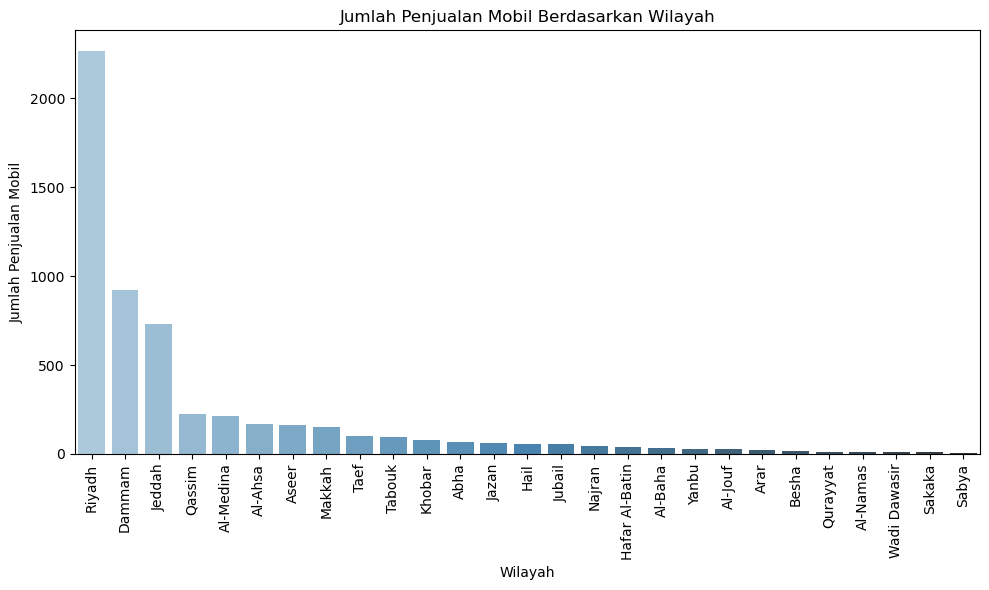

In [11]:
sales_by_region = data['Region'].value_counts()
average_price_by_region = data.groupby('Region')['Price'].mean()
print("Jumlah penjualan mobil per wilayah:")
print(sales_by_region)
print("\nHarga rata-rata mobil per wilayah:")
print(average_price_by_region)
plt.figure(figsize=(10,6))
sns.barplot(x=sales_by_region.index, y=sales_by_region.values, palette='Blues_d')
plt.title('Jumlah Penjualan Mobil Berdasarkan Wilayah')
plt.xlabel('Wilayah')
plt.ylabel('Jumlah Penjualan Mobil')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


berdasarkan data yang kita terima untuk daerah penjualan mobil terbanyak di riyadh, dammam dan jeddah, maka untuk Implementasi Bisnis:

- Perusahaan mungkin ingin fokus pada Riyadh, Dammam, dan Jeddah untuk pemasaran lebih lanjut karena potensi penjualan yang lebih besar.

------------------------

Penyelesaian Rumusan: Harga rata rata di setiap wilayah, hal ini bertujuan untuk membandingan satu wilayah dengan wilayah lainnya

Harga rata-rata mobil per wilayah:
Region
Abha              24757.968750
Al-Ahsa           42908.530120
Al-Baha           28028.571429
Al-Jouf           33474.962963
Al-Medina         33077.831776
Al-Namas          39833.333333
Arar              12003.818182
Aseer             35741.846626
Besha              9312.500000
Dammam            75395.779221
Hafar Al-Batin    19982.051282
Hail              22325.931034
Jazan             37525.000000
Jeddah            55385.049180
Jubail            28428.571429
Khobar            48492.921053
Makkah            40215.450980
Najran            23478.476190
Qassim            39590.955556
Qurayyat          16076.923077
Riyadh            57705.660793
Sabya              8750.000000
Sakaka            32000.000000
Tabouk            24772.113402
Taef              30294.077670
Wadi Dawasir      24083.333333
Yanbu             27111.111111
Name: Price, dtype: float64


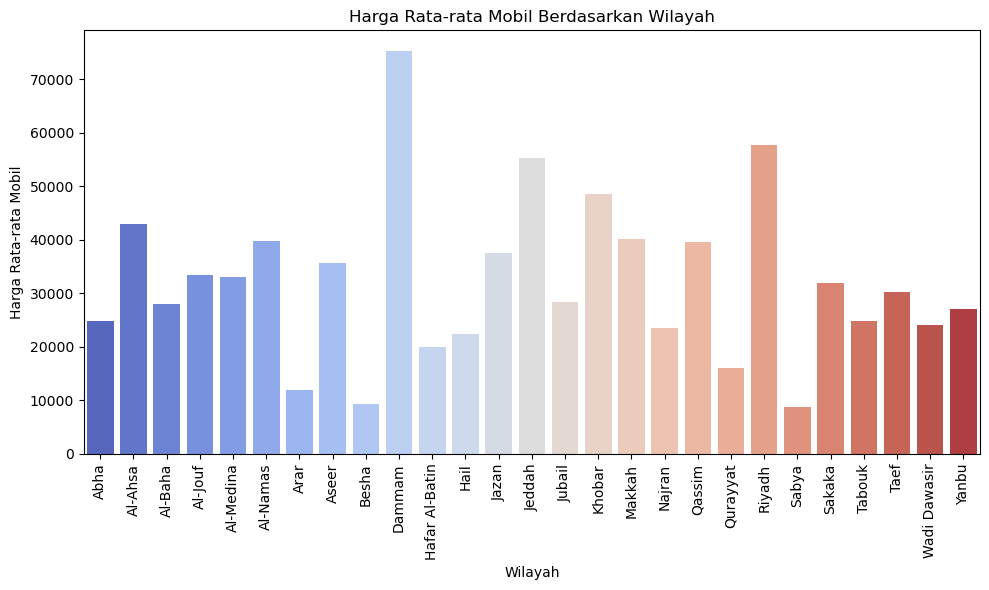

In [12]:
average_price_by_region = data.groupby('Region')['Price'].mean()
print("Harga rata-rata mobil per wilayah:")
print(average_price_by_region)
plt.figure(figsize=(10,6))
sns.barplot(x=average_price_by_region.index, y=average_price_by_region.values, palette='coolwarm')
plt.title('Harga Rata-rata Mobil Berdasarkan Wilayah')
plt.xlabel('Wilayah')
plt.ylabel('Harga Rata-rata Mobil')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

berdarkan data diatas maka kita dapat menyimpulkan :
- potensi untuk daerah Dammam memiliki harga rata-rata mobil tertinggi, mendekati 90,000, jauh lebih tinggi daripada wilayah lainnya.
Wilayah dengan harga rata-rata tinggi lainnya: Riyadh, Sakaka, Sabya, dan Qurrayat.
Al-Ahsa, Al-Baha, Al-Jouf, dan Al-Namas memiliki harga rata-rata mobil yang relatif lebih rendah, sekitar 50,000.
Wilayah dengan harga rata-rata terendah: Wadi Dawasir dan Yanbu, di bawah 50,000.

maka untuk implementasi bisnis maka baikkan:
- Wilayah dengan harga rata-rata tinggi seperti Dammam dan Riyadh mungkin memiliki target konsumen dengan daya beli lebih tinggi, yang bisa diprioritaskan untuk penjualan mobil premium.
Wilayah dengan harga rendah mungkin lebih cocok untuk mobil yang lebih terjangkau, sehingga strategi penjualan dan pemasaran harus disesuaikan berdasarkan harga yang kompetitif.

--------------------------

rumusan masalah: 
- kita menganalisa uji hipotesa hubungan antara harga rata-rata dan penjualan 

Korelasi antara harga rata-rata dan penjualan: 0.641508222410826


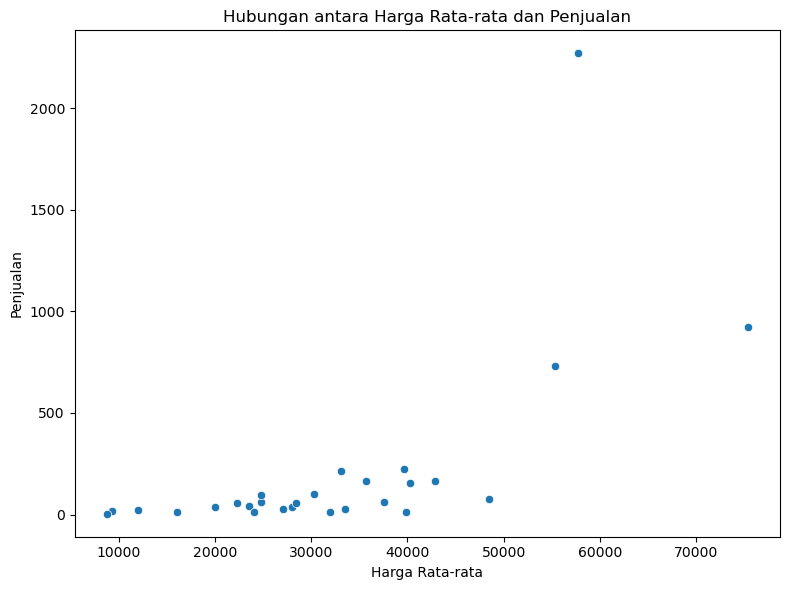

In [13]:
sales_by_region = data['Region'].value_counts()
average_price_by_region = data.groupby('Region')['Price'].mean()
price_sales_df = pd.DataFrame({
    'Average_Price': average_price_by_region,
    'Sales': sales_by_region
})
correlation = price_sales_df.corr().loc['Average_Price', 'Sales']
print(f"Korelasi antara harga rata-rata dan penjualan: {correlation}")
plt.figure(figsize=(8,6))
sns.scatterplot(x=price_sales_df['Average_Price'], y=price_sales_df['Sales'])
plt.title('Hubungan antara Harga Rata-rata dan Penjualan')
plt.xlabel('Harga Rata-rata')
plt.ylabel('Penjualan')
plt.tight_layout()
plt.show()



berdasarkan data diatas kita mempunyai kesimpulan bahwasanya korelasi sebesar 0.569 menunjukkan bahwa ada korelasi positif sedang antara harga rata-rata mobil dan jumlah penjualan. Ini berarti bahwa ketika harga rata-rata mobil di suatu wilayah meningkat, secara umum penjualan di wilayah tersebut juga cenderung meningkat.

jika kita melihat data-data sebelumnya kita dapat menarik benang merah bahwasanya:
- Wilayah dengan harga tinggi seperti Riyadh tidak hanya memiliki harga rata-rata yang lebih tinggi tetapi juga penjualan yang tinggi, yang menunjukkan bahwa pasar ini memiliki daya beli yang kuat.

-------------------------------------------

rumusan masalah: 
- data yang ingin kita cari ialah analisis tentang daerah potensial berdasarkan merek dan tipe mobil.

tujuan kita:
- Mengidentifikasi wilayah potensial untuk berbagai merek mobil.
- Mengidentifikasi wilayah potensial untuk berbagai tipe mobil.

10 Kombinasi Wilayah dan Merek Mobil dengan Penjualan Tertinggi:
     Region       Make  Sales
402  Riyadh     Toyota    490
379  Riyadh    Hyundai    327
175  Dammam     Toyota    251
370  Riyadh       Ford    211
363  Riyadh  Chevrolet    197
395  Riyadh     Nissan    181
255  Jeddah     Toyota    167
373  Riyadh        GMC    112
385  Riyadh        Kia    102
147  Dammam       Ford    101


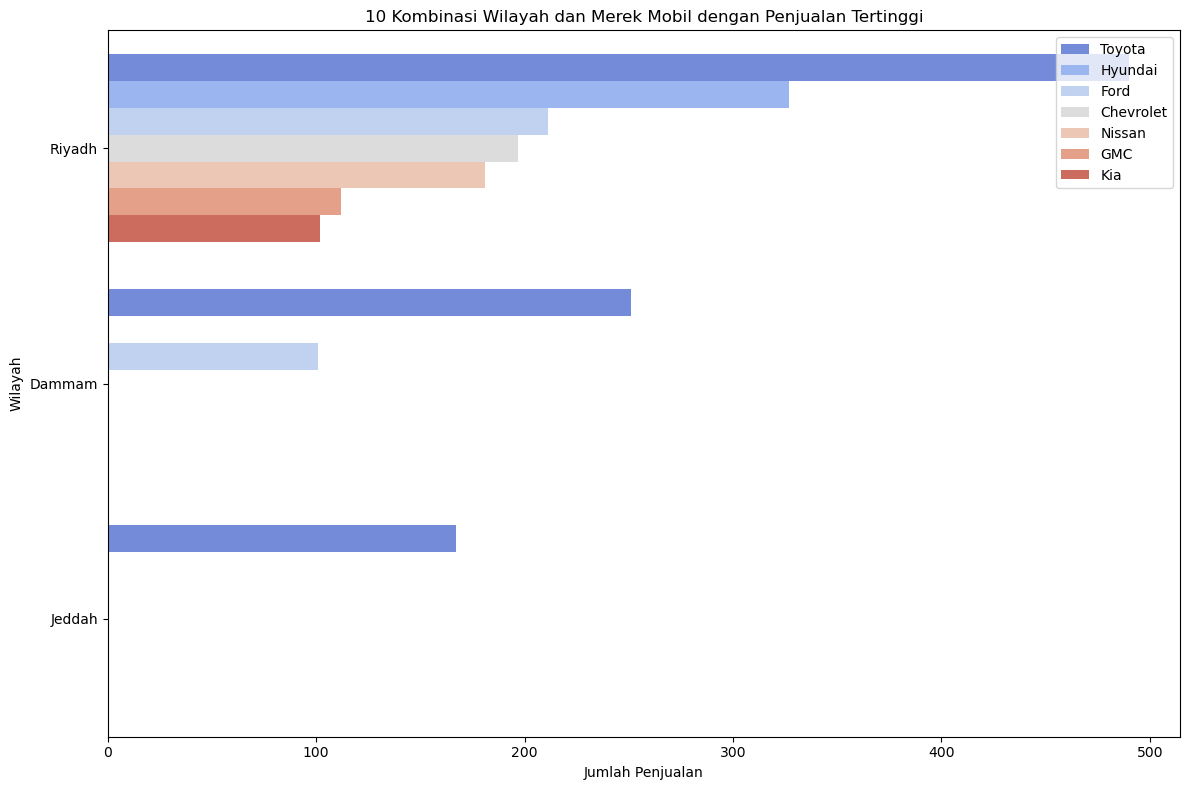

In [14]:
# 1. Menghitung jumlah penjualan per wilayah berdasarkan merek mobil
sales_by_region_and_make = data.groupby(['Region', 'Make']).size().reset_index(name='Sales')

# 2. Menampilkan 10 kombinasi wilayah dan merek dengan penjualan tertinggi
top_region_make_sales = sales_by_region_and_make.sort_values(by='Sales', ascending=False).head(10)
print("10 Kombinasi Wilayah dan Merek Mobil dengan Penjualan Tertinggi:")
print(top_region_make_sales)

# 3. Visualisasi penjualan mobil per wilayah dan merek
plt.figure(figsize=(12,8))
sns.barplot(x='Sales', y='Region', hue='Make', data=top_region_make_sales, palette='coolwarm')
plt.title('10 Kombinasi Wilayah dan Merek Mobil dengan Penjualan Tertinggi')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Wilayah')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


- Toyota adalah merek mobil paling populer di ketiga wilayah (Riyadh, Dammam, dan Jeddah).
- Riyadh adalah pasar paling potensial untuk berbagai merek mobil, dengan penjualan yang signifikan untuk merek-merek seperti Hyundai, Chevrolet, dan Nissan.
- Dammam juga merupakan pasar yang potensial untuk merek-merek seperti Toyota dan Hyundai, sementara Jeddah tampaknya lebih spesifik untuk Toyota.


10 Kombinasi Wilayah dan Tipe Mobil dengan Penjualan Tertinggi:
      Region          Type  Sales
1264  Riyadh  Land Cruiser     92
1326  Riyadh        Sonata     84
1141  Riyadh        Accent     83
1174  Riyadh         Camry     80
1366  Riyadh         Yukon     71
1337  Riyadh         Tahoe     65
1214  Riyadh       Elantra     64
1248  Riyadh         Hilux     63
1217  Riyadh    Expedition     59
1338  Riyadh        Taurus     52


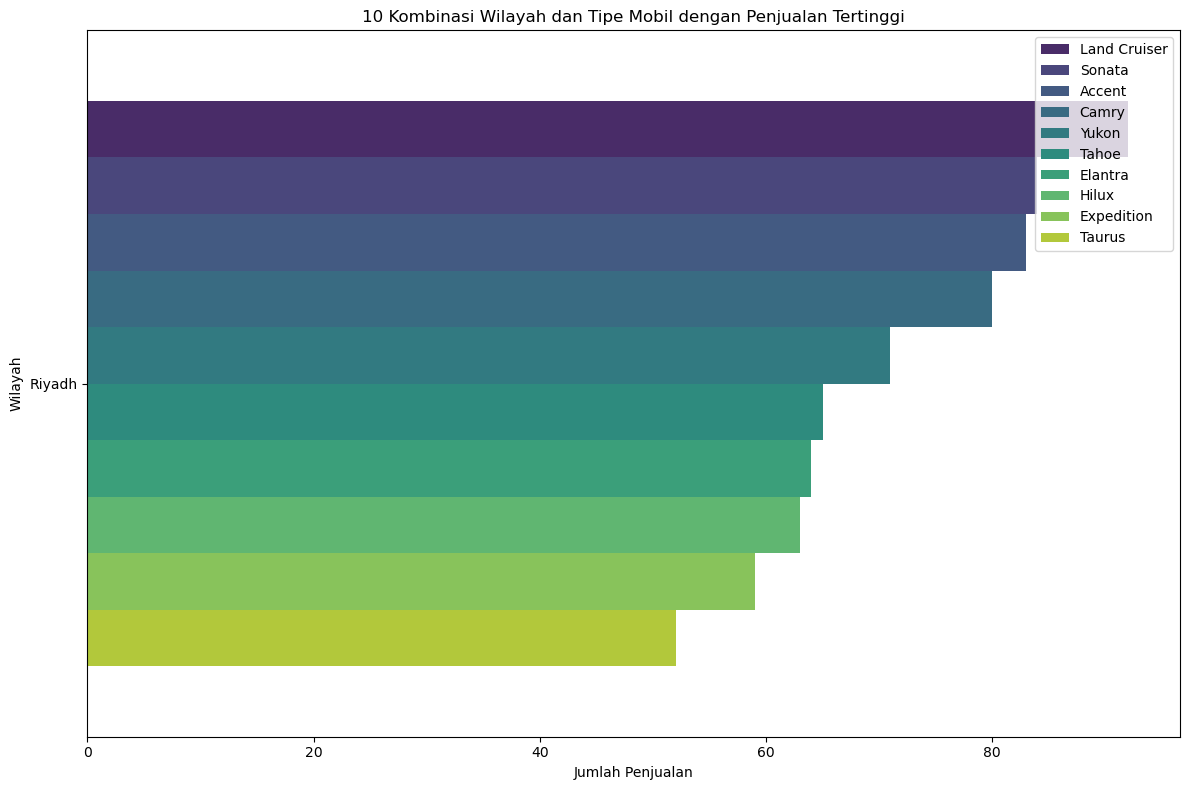

In [15]:
# 4. Menghitung jumlah penjualan per wilayah berdasarkan tipe mobil
sales_by_region_and_type = data.groupby(['Region', 'Type']).size().reset_index(name='Sales')

# 5. Menampilkan 10 kombinasi wilayah dan tipe mobil dengan penjualan tertinggi
top_region_type_sales = sales_by_region_and_type.sort_values(by='Sales', ascending=False).head(10)
print("\n10 Kombinasi Wilayah dan Tipe Mobil dengan Penjualan Tertinggi:")
print(top_region_type_sales)

# 6. Visualisasi penjualan mobil per wilayah dan tipe
plt.figure(figsize=(12,8))
sns.barplot(x='Sales', y='Region', hue='Type', data=top_region_type_sales, palette='viridis')
plt.title('10 Kombinasi Wilayah dan Tipe Mobil dengan Penjualan Tertinggi')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Wilayah')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

- Tipe sedan seperti Accent, Sonata, dan Elantra sangat populer di Riyadh, sedangkan tipe SUV juga diminati.
- Dammam lebih fokus pada tipe mobil ekonomis seperti Sunny, yang menunjukkan bahwa pasar di sana mungkin lebih sensitif terhadap harga dibandingkan Riyadh.
- Wilayah Riyadh memiliki pasar yang lebih beragam dalam hal tipe mobil, dengan preferensi baik untuk sedan maupun SUV.

--------------
kesimpulan dari dua data tersebut:
- Riyadh adalah pasar paling potensial untuk berbagai merek dan tipe mobil. Toyota dan Hyundai memiliki penjualan yang kuat di sini, dengan berbagai tipe mobil dari sedan hingga SUV.

- Fokus pemasaran di Riyadh bisa diarahkan ke mobil-mobil premium seperti Land Cruiser dan Camry, serta mobil ekonomis seperti Accent.
Dammam menunjukkan permintaan yang lebih kuat untuk mobil ekonomis seperti Sunny dan Accent, sementara Toyota tetap menjadi pemain utama di wilayah ini.

- Pemasaran di Dammam bisa berfokus pada mobil dengan harga lebih terjangkau, khususnya sedan.
Jeddah masih berpotensi, terutama untuk merek Toyota, meskipun volumenya lebih rendah dibandingkan Riyadh dan Dammam.

---------------
-----------------

**Prediksi Harga mobil**

1. Data Preprocessing:
- Fitur Input (X): Pilih fitur-fitur yang relevan untuk memprediksi harga mobil, misalnya Make, Type, Year, Mileage, Region, Engine_Size, dan Gear_Type.
- Target Output (y): Kolom yang diprediksi adalah Price (harga mobil).
- Feature Encoding: XGBoost Regressor tidak bekerja langsung dengan fitur kategoris, sehingga kolom kategoris seperti Make, Type, dan Region perlu diubah menggunakan One-Hot Encoding atau Label Encoding.

2. Pemilihan Algoritma:
- XGBoost Regressor dipilih karena kemampuannya yang kuat dalam menangani dataset besar dan kompleks. Algoritma ini adalah metode boosting yang membangun model secara bertahap dengan memperbaiki kesalahan prediksi dari model sebelumnya, sehingga menghasilkan prediksi yang lebih akurat.
- XGBoost juga mendukung regularisasi yang membantu mengurangi overfitting dan sering kali lebih efisien daripada algoritma ensemble lainnya seperti Random Forest.

3. Kapan XGBoost Dapat Dipercaya:
- Ketika data memiliki variasi yang cukup besar: XGBoost bekerja dengan baik pada dataset yang memiliki banyak variasi dalam fitur-fitur numerik seperti Year, Mileage, dan Engine_Size, serta fitur kategoris setelah diencoding.
- R² mendekati 1 dan MAE rendah: Ketika evaluasi model menghasilkan R² yang mendekati 1 dan MAE yang rendah, ini menunjukkan bahwa model XGBoost telah melakukan pekerjaan yang baik dalam memprediksi harga mobil.

4. Limitasi Model:
- Konsumsi memori dan waktu yang lebih tinggi: XGBoost membutuhkan lebih banyak waktu dan memori daripada model ensemble lainnya, terutama pada dataset yang sangat besar. Namun, ini bisa dikurangi dengan menggunakan parameter tuning yang tepat dan menerapkan teknik seperti early stopping.
- Lebih sulit diinterpretasikan: Seperti halnya Random Forest, XGBoost tidak memberikan hubungan matematis yang jelas antara input dan output, membuatnya sulit untuk diinterpretasikan secara langsung. Namun, pentingnya fitur bisa dihitung dengan mudah menggunakan feature importance.

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Definisikan parameter grid untuk tuning
param_grid = {
    'n_estimators': [100, 500, 800],
    'max_depth': [7, 8, 10, 14],
    'learning_rate': [0.02, 0.2, 0.3],
    'subsample': [0.8, 0.8, 0.9],
    'colsample_bytree': [0.8, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1]
}

# Buat objek RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # jumlah iterasi (semakin besar, semakin teliti, tapi butuh waktu lebih lama)
    scoring='neg_mean_squared_error',  # metrik evaluasi yang digunakan
    cv=5,  # cross-validation dengan 5 fold
    verbose=1,  # menampilkan output proses
    random_state=42,
    n_jobs=-1  # gunakan semua prosesor yang tersedia untuk mempercepat proses
)

# Lakukan pencarian hyperparameter
random_search.fit(X_train, y_train)

# Tampilkan parameter terbaik
print(f"Best parameters found: {random_search.best_params_}")

# Gunakan model dengan parameter terbaik
best_xgb_model = random_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)

# Evaluasi model dengan parameter terbaik
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
predictions_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_best, 'Index': y_test.index})
print(predictions_df.head(10))

print(f'Best MAE: {mae_best}')
print(f'Best RMSE: {rmse_best}')
print(f'Best R²: {r2_best}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 0.5, 'colsample_bytree': 0.8}
   Actual      Predicted  Index
0   49000   63353.011719   4578
1   35000   15315.271484   5460
2   45000   40191.628906   2871
3   22000   25433.226562   3502
4   20000   32651.812500   2178
5  105000   92745.468750   1711
6   30000   58671.082031    483
7   18000   25385.015625   1240
8   70000   68430.945312   1328
9  120000  126747.125000   1452
Best MAE: 13746.207231030434
Best RMSE: 25835.312113296215
Best R²: 0.8819643337402376
